# Research and AI at Scale

## Classification Example: MNIST dataset

In this tutorial, we will create a neural network for identifying numbers based on handwritten digits.

When the input to the model is an image of the handwritten number 7, the prediction should also be 7.

To train and validate a neural network, there must be a large number of examples of each digit.

The MNIST (Modified National Institute of Standards and Technology) dataset is one of the standard benchmark datasets for handwritten digit classification.

About the MNIST dataset:
* Collection of handwritten digits ranging from numbers 0 to 9.
* The training set has 60,000 images.
* The testing set has 10,000 images.
* All of the images are labelled.


In [7]:
# Import the necessary libraries
import keras

# For linear algebra
import numpy as np

import tensorflow

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For accessing our dataset
from keras.datasets import mnist

# For encoding our labels
from keras.utils import to_categorical, plot_model


### Section 1: Load and visualize the data

In [2]:
# Load the data - note it is already divided into train and test sets
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

# Count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))

#  Explore the data. Look at the sizes of the training and testing sets.
print("\nTrain shape: {}".format(x_train.shape))
print("\nTest shape: {}".format(x_test.shape))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}

Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}

Train shape: (60000, 28, 28)

Test shape: (10000, 28, 28)


### Visualize the Data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

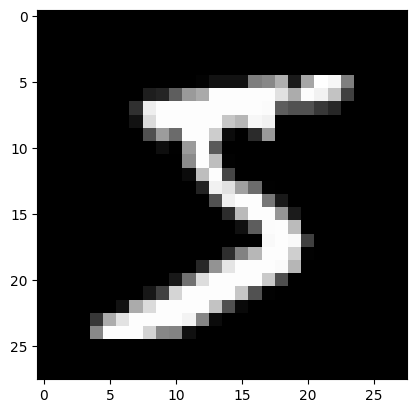

In [8]:
# We can visualize the first image
plt.figure()
plt.imshow(x_train[0,:,:], cmap='gray')


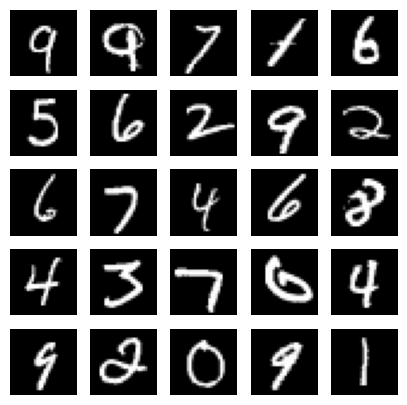

In [9]:
# We can also randomly sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]


# Plot 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

## Section 2: Preprocessing the Data

In deep learning, data is stored in tensors. There can be many different forms of tensors
* Scalar (0-dimensional tensor)
* Vector (1-dimensional tensor)
* Matrix (2-dimensional tensor)
* Multi-dimensional

Since our images are black and white, the pixel values range from 0 to 255.

Although we can use raw pixel values directly, it is better to normalize the input data. This can make training easier because it helps to avoid large gradient values.

If you are interested in learning more about gradients, here are some helpful resources:
   * https://towardsdatascience.com/machine-learning-101-an-intuitive-introduction-to-gradient-descent-366b77b52645
   * https://www.ibm.com/think/topics/gradient-descent

### Preprocessing the data

In [10]:
# let's look at the minimum and maximum pixel values
print("Minimum pixel value: {}\n".format(np.amin(x_train)))
print("Maximum pixel value: {}\n".format(np.amax(x_train)))

# Let's see what data type the pixels are. Keras needs the data to be of type float32
print(type(x_train[0,0,0]))

# Since the pixels in the images are of type uint8, they will need to be converted to float32.


Minimum pixel value: 0

Maximum pixel value: 255

<class 'numpy.uint8'>


In [11]:
# Find image dimensions
image_size = x_train.shape[1]
input_size = image_size * image_size
print("Image size: {}\n".format(image_size))

# Reshape the image tensors.
# Keras needs the image tensors to have a channel dimesnion, even if there is only one channel
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

# Convert the pixels to float32 type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Rescale the pixel values to run from 0 to 1. This is called normalizing the data.
# We divide by 255 because that is the maximum value.
x_train = x_train / 255
x_test = x_test / 255

Image size: 28



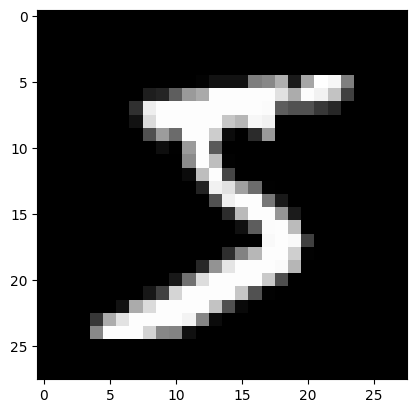

In [13]:
# Let's visualize the first image again.
plt.imshow(x_train[0,:,:,0], cmap='gray')

# Notice that the transformations we made do not affect its appearance.

### Preprocessing the labels

In [14]:
# Let's see how many labels we have
num_labels = len(np.unique(y_train))
print("Number of labels: {}\n".format(num_labels))

# Let's see the data type for the training labels.
print(y_train.shape)
print(y_train[0])

Number of labels: 10

(60000,)
5


* Our labels are digits ranging from 0 to 9.
* This sparse scalar representation isn't the best choice for our neural network. We don't want the model to give more importance to higher numbers when it is learning.
* A more suitable format is to use **one-hot encoding**.
* Our one-hot vectors wil have all elements of 0, except for the index of the digit class.
* For example, if the label is 1, the equivalent one-hot vector is: [0,0,**1**,0,0,0,0,0,0,0]
* Remember the first label has index 0.

In [15]:
# Convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Take a look at one of the one-hot vectors after conversion
print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Section 3: Define hyperparameters

We are alomst ready to set up our deep learning model. Since we will be training it, we need to first define some **hyperparameters**, which will control how the model learns.

Our deep learning model will have 3 hyperparameters.
* **Batch Size**: indicates the amount of data we will use for each update of the model parameters.
* **Epoch**: An epoch is one complete pass through the entire training dataset during the learning process. Think of it as teaching a model by showing it all the data once.
* **Learning Rate**: A small number that controls how much the model's weights change with each step during training. It’s like adjusting the speed of learning—too fast can miss details, too slow takes a long time to learn.

In [16]:
# Defining hyperparameters
my_batch_size = 32
my_epochs = 25
my_learning_rate = 0.001

### Section 4: Defining the network



In [17]:
# Compute the shape of the input image to define the input layer.
# Note the addition of a channel dimension, even for single-channel images.
img_shape = (x_train.shape[1], x_train.shape[2], 1)

# Define the layers of a five-layer network.
input_layer = keras.layers.Input(img_shape)
layer_0 = keras.layers.Flatten()(input_layer)
layer_1 = keras.layers.Dense(100, activation='sigmoid')(layer_0)
layer_2 = keras.layers.Dense(200, activation='sigmoid')(layer_1)
output = keras.layers.Dense(10)(layer_2)

# Build them into a model.
model = keras.models.Model(inputs=input_layer, outputs=output)

# Compile the model to perform any precomputations possible to speed up backpropagation.
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(learning_rate=my_learning_rate),
             metrics=['accuracy'])

# Look at a summary of the model.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,710 (393.40 KB)

 Trainable params: 100,710 (393.40 KB)

 Non-trainable params: 0 (0.00 B)

### Section 5: Train the Network

In [18]:
model.fit(x=x_train, y=y_train, batch_size=my_batch_size, epochs=my_epochs)

Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7462 - loss: 0.0614
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9332 - loss: 0.0155
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9522 - loss: 0.0118
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9619 - loss: 0.0099
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9657 - loss: 0.0090
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9717 - loss: 0.0079
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9730 - loss: 0.0072
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9745 - loss: 0.0067
Epoch 9/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9775 - loss: 0.0060
Epoch 10/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9800 - loss: 0.0054
Epoch 11/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9828 - loss: 0.0049
Epoch 12/25
1875/1875 ━━━━━━━━

### Section 6: Make Predictions

In [19]:
results = model.predict(x_test, batch_size=my_batch_size)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### Section 7: Evaluate Perforamce

In [20]:
loss, acc = model.evaluate(x_test, y_test, batch_size=my_batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9737 - loss: 0.0046

Test accuracy: 97.8%


### Section 8: Visualize Results


[ 2.94592418e-03  1.00750458e+00 -6.91911206e-03  1.10627115e-02
 -4.93720919e-03 -6.59689307e-03 -5.57687134e-04 -1.10833347e-03
  1.54838711e-03 -4.01805155e-03]
1


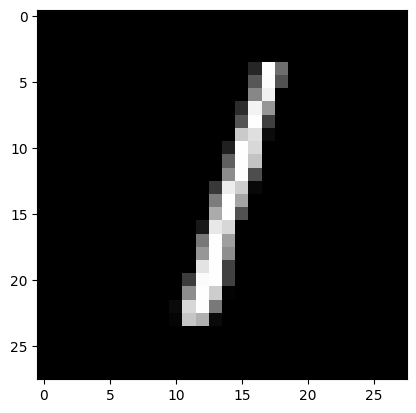

In [21]:
# Look at one of the results.  Note that it is a 10-vector where the highest value indicates the index of the predicted digit.
print(results[2,:])

# See the index of the predicted digit directly.
print(np.argmax(results[2,:]))

# Look at the image of the digit to see if it matches the predicted digit.
plt.imshow(x_test[2,:,:,0], cmap='gray')


### Try It Out

In [ ]:
# What happens when you change the learning_rate?

In [ ]:
# What happens when you change the batch size?

In [ ]:
# What happens when you change the number of epoch?

In [ ]:
# What happens if you add an extra hidden layer?

In [ ]:
# What happens if you remove a hidden layer?

In [24]:
# Challenge: try to out other neural network architectures!

# Hint: https://www.kaggle.com/code/amyjang/tensorflow-mnist-cnn-tutorial
# Hint: https://www.kaggle.com/code/prashant111/mnist-deep-neural-network-with-keras